In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import seaborn as sb

import pandas as pd
from keras import layers
from keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
data_dir = "./cv-corpus-7.0-singleword/fr/"
val_set = pd.read_csv(data_dir + '/validated.tsv', sep='\t')
test_set = pd.read_csv(data_dir + '/test.tsv', sep='\t')
train_set = pd.read_csv(data_dir + '/train.tsv', sep='\t')
val_set.head()

,client_id,path,sentence,up_votes,down_votes,age,gender,accent,locale,segment
0,02ccda0cd258d89228fc66cb072eb9bafbb1ae9f39dc8b...,common_voice_fr_23890678.mp3,huit,2,0,NaN,NaN,NaN,fr,Benchmark
1,05a87054181791477a299a08fc35a6ff0c53250cae313e...,common_voice_fr_22108074.mp3,zéro,2,0,NaN,NaN,NaN,fr,Benchmark
2,06c9c9e703dfa759edf4836936b42a07afd1021cedb06c...,common_voice_fr_22098482.mp3,trois,2,0,NaN,NaN,NaN,fr,Benchmark
3,07a7db773acd156dd0b7fdc32f6b5eda9b32ffa1b3aee7...,common_voice_fr_21955578.mp3,quatre,6,3,NaN,NaN,NaN,fr,Benchmark
4,0eb85c7dcb9b7ca2caec05a0dbbf6ee983cfab19164dac...,common_voice_fr_22157149.mp3,Firefox,3,1,NaN,NaN,NaN,fr,Benchmark


In [3]:
def filter_set(set):
    return set[(set['sentence'] == 'oui') |
                (set['sentence'] == 'non') |
                (set['sentence'] == 'un') |
                (set['sentence'] == 'deux') |
                (set['sentence'] == 'trois') |
                (set['sentence'] == 'quatre')]
validated_files = filter_set(val_set)
train_files = filter_set(train_set)
test_files = filter_set(test_set)


DATASET_PATH = data_dir + "/clips/"
example_filpath = validated_files['path'].iloc[0]

print("Nb valid :", validated_files.size)
print("Nb train : ", train_files.size)
print("Nb test : ", test_files.size)

train_files.head(10)



Nb valid : 86520
Nb train :  37170
Nb test :  24730


,client_id,path,sentence,up_votes,down_votes,age,gender,accent,locale,segment
2,89fa8146b2c07e3e2fe2bbf3852ed8b22a625e383df7eb...,common_voice_fr_21982262.mp3,trois,3,0,teens,male,france,fr,Benchmark
3,89fa8146b2c07e3e2fe2bbf3852ed8b22a625e383df7eb...,common_voice_fr_21982265.mp3,deux,3,2,teens,male,france,fr,Benchmark
5,89fa8146b2c07e3e2fe2bbf3852ed8b22a625e383df7eb...,common_voice_fr_21982432.mp3,non,3,0,teens,male,france,fr,Benchmark
8,89fa8146b2c07e3e2fe2bbf3852ed8b22a625e383df7eb...,common_voice_fr_21982436.mp3,un,4,1,teens,male,france,fr,Benchmark
9,89fa8146b2c07e3e2fe2bbf3852ed8b22a625e383df7eb...,common_voice_fr_21982502.mp3,quatre,2,0,teens,male,france,fr,Benchmark
10,89fa8146b2c07e3e2fe2bbf3852ed8b22a625e383df7eb...,common_voice_fr_21982503.mp3,oui,3,0,teens,male,france,fr,Benchmark
14,8b6b5f3aa812daa683fbd2ef527c4ab1cdd86dbfbe1e50...,common_voice_fr_21974685.mp3,quatre,2,0,NaN,NaN,NaN,fr,Benchmark
15,8b6b5f3aa812daa683fbd2ef527c4ab1cdd86dbfbe1e50...,common_voice_fr_21974688.mp3,trois,3,2,NaN,NaN,NaN,fr,Benchmark
17,8b6b5f3aa812daa683fbd2ef527c4ab1cdd86dbfbe1e50...,common_voice_fr_21974694.mp3,deux,2,1,NaN,NaN,NaN,fr,Benchmark
19,8b6b5f3aa812daa683fbd2ef527c4ab1cdd86dbfbe1e50...,common_voice_fr_21974787.mp3,oui,5,1,NaN,NaN,NaN,fr,Benchmark


tf.Tensor(
[ 0.0000000e+00  1.4890310e-16 -1.0353580e-16 ...  1.1913221e-04
 -8.1312137e-06 -1.4327871e-04], shape=(149760,), dtype=float32)


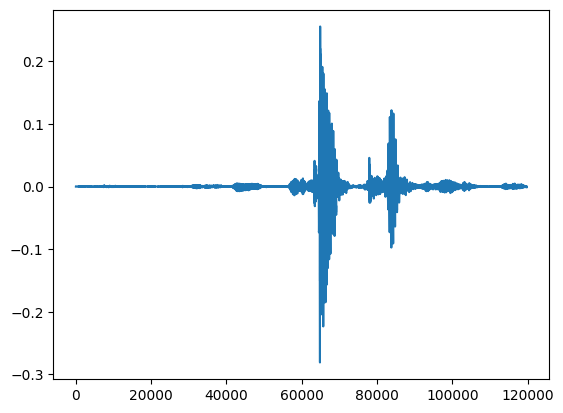

In [4]:
def decode_audio(file_path):
  # Decode MPD3-encoded audio files to tf files
  file = tf.io.read_file(DATASET_PATH + file_path)
  audio= tfio.audio.decode_mp3(file)
  return tf.squeeze(audio, axis=-1)

print(decode_audio(example_filpath))


audio = decode_audio('output_v2.mp3')
plt.plot(audio.numpy())
plt.show()

In [5]:
labels = ['oui', 'non', 'un', 'deux', 'trois', 'quatre']

def get_spectrogram(file_path):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  waveform = decode_audio(file_path[0])
  input_len = 150000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      input_len - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram, tf.argmax(file_path[1] == labels)


In [6]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_files(files):
    files_dataset = tf.data.Dataset.from_tensor_slices(files)
    preprocessed_dataset = files_dataset.map(
        map_func = get_spectrogram,
        num_parallel_calls=AUTOTUNE
    )
    return preprocessed_dataset

def preprocess_from_path(path):
    set = pd.read_csv(data_dir + path, sep='\t')
    set = filter_set(set)
    files = set[['path', 'sentence']]
    dataset = preprocess_files(files)
    return dataset


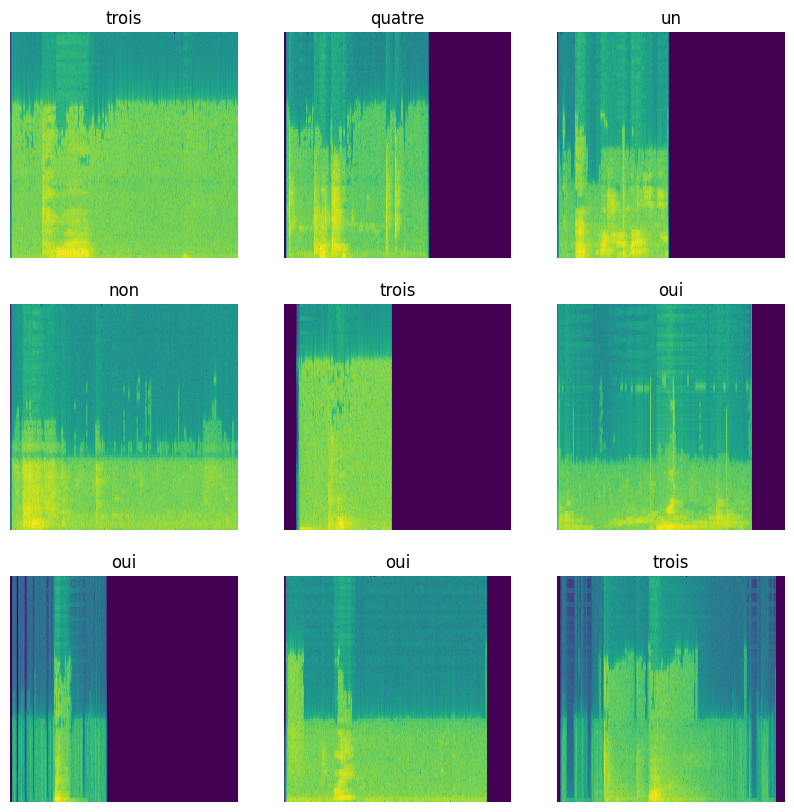

In [8]:
ds = preprocess_from_path('test.tsv') 
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label) in enumerate(ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(labels[label])
  ax.axis('off')

plt.show()


In [9]:
train_ds = preprocess_from_path('train.tsv')
val_ds = preprocess_from_path('validated.tsv')
test_ds = preprocess_from_path('test.tsv')

batch_size = 4
train_ds_batch = train_ds.batch(batch_size)
val_ds_batch = val_ds.batch(batch_size)
test_ds_batch = test_ds.batch(batch_size)

train_ds_batch = train_ds_batch.cache().prefetch(AUTOTUNE)
val_ds_batch = val_ds_batch.cache().prefetch(AUTOTUNE)
test_ds_batch = test_ds_batch.cache().prefetch(AUTOTUNE)

In [10]:
for spectrogram, _ in train_ds.take(1):  
    input_shape = spectrogram.shape
    print('Input shape:', input_shape)
num_labels = len(labels)
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32,32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (1170, 129, 1)
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPoolin

In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [12]:
EPOCHS = 20
history = model.fit(
    train_ds_batch,
    validation_data=val_ds_batch,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
930/930 [==============================] - 247s 265ms/step - loss: 1.3811 - accuracy: 0.4646 - val_loss: 1.0752 - val_accuracy: 0.6156
Epoch 2/20
930/930 [==============================] - 97s 104ms/step - loss: 1.0461 - accuracy: 0.6258 - val_loss: 0.8938 - val_accuracy: 0.7138
Epoch 3/20
930/930 [==============================] - 44s 47ms/step - loss: 0.8337 - accuracy: 0.7041 - val_loss: 1.2003 - val_accuracy: 0.6010
Epoch 4/20
930/930 [==============================] - 38s 41ms/step - loss: 0.7005 - accuracy: 0.7598 - val_loss: 0.6483 - val_accuracy: 0.7909
Epoch 5/20
930/930 [==============================] - 38s 41ms/step - loss: 0.5979 - accuracy: 0.7950 - val_loss: 0.6359 - val_accuracy: 0.8011
Epoch 6/20
930/930 [==============================] - 38s 40ms/step - loss: 0.5047 - accuracy: 0.8265 - val_loss: 0.5763 - val_accuracy: 0.8247
Epoch 7/20
930/930 [==============================] - 39s 42ms/step - loss: 0.4394 - accuracy: 0.8421 - val_loss: 0.5615 - val_accura

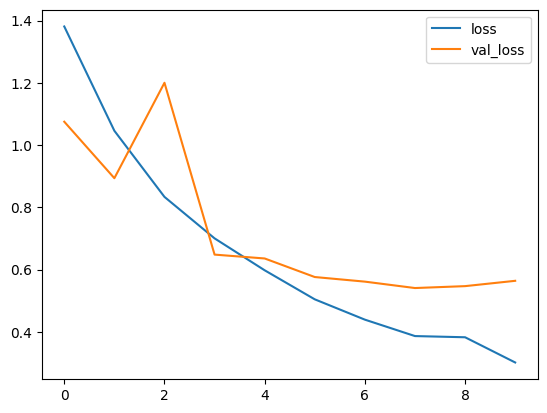

In [13]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [14]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

78/78 [==============================] - 4s 35ms/step
Test set accuracy: 77%


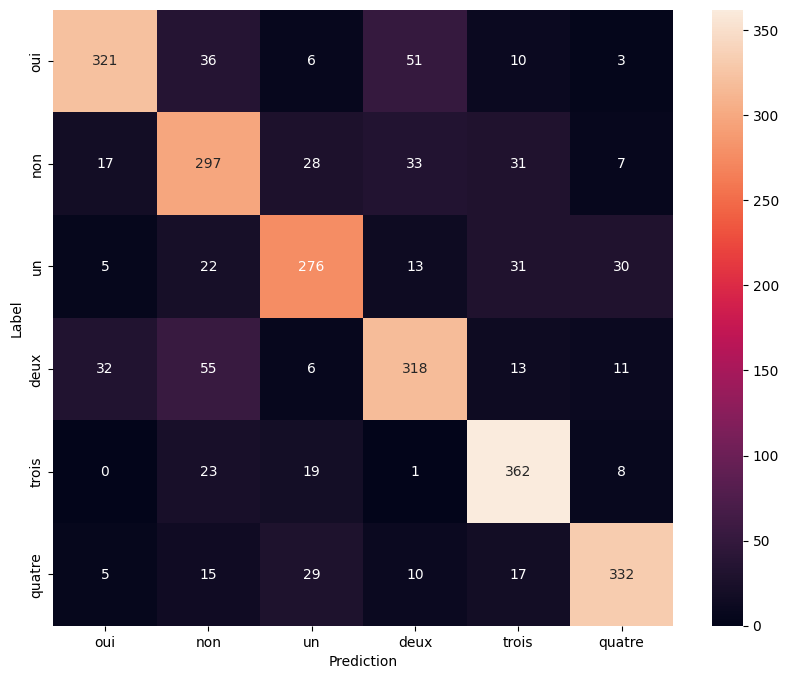

In [15]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sb.heatmap(confusion_mtx,
            xticklabels=labels,
            yticklabels=labels,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

                             path sentence
3    common_voice_fr_21955578.mp3   quatre
714  common_voice_fr_22167741.mp3      non
790  common_voice_fr_22123871.mp3       un
0    common_voice_fr_22199693.mp3     test
Predicted : trois


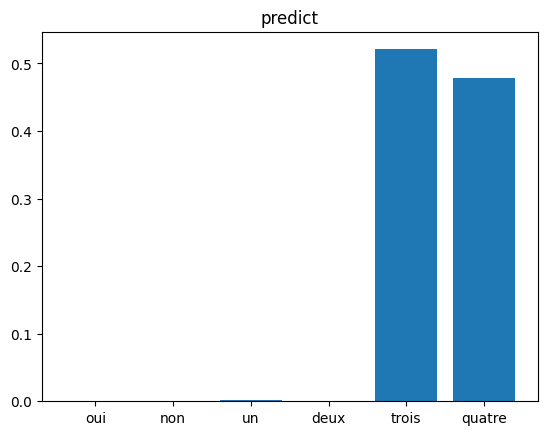

Predicted : trois


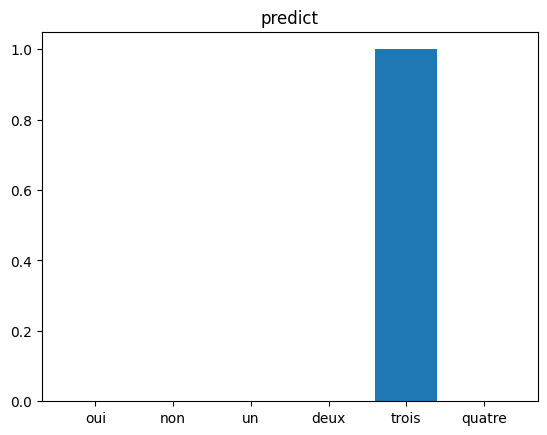

Predicted : un


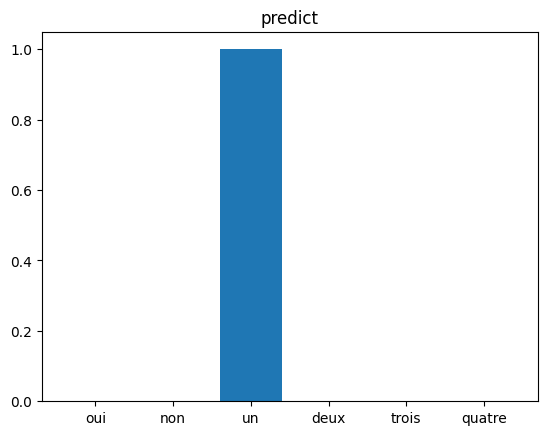

Predicted : trois


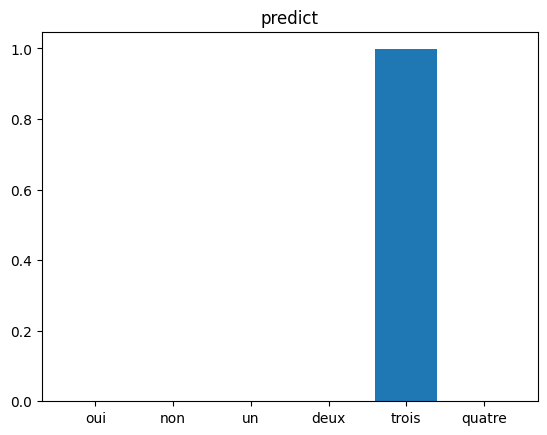

In [19]:
sample_file = val_set[(val_set['path']=='common_voice_fr_21955578.mp3') | (val_set['path']=='common_voice_fr_22123871.mp3') | (val_set['path']=='common_voice_fr_22167741.mp3')][['path', 'sentence']]

test_file = 'common_voice_fr_22199693.mp3'
test = pd.DataFrame({'path' : [test_file], 'sentence': ['test']})
sample_file = sample_file.append(test)
print(sample_file)

sample_ds = preprocess_files(sample_file)

for spectrogram, label in sample_ds.batch(1):   
  prediction = model(spectrogram)
  plt.bar(labels, tf.nn.softmax(prediction[0]))
  plt.title('predict')
  print("Predicted :", labels[np.argmax(tf.nn.softmax(prediction[0]))])
  plt.show()

model.save('model.h5')
reconstructed_model = tf.keras.models.load_model("model.h5")

In [17]:
import pyaudio
import wave

CHUNK = 1024
FORMAT = pyaudio.paInt32
CHANNELS = 1
RATE = 48000
RECORD_SECONDS = 2.5
WAVE_OUTPUT_FILENAME = DATASET_PATH + "output"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

print("* recording")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME + '.wav', 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

### ATTENTION : Obligé d'installer ffmpeg pour que cette partie fonctionne, mais c'est que pour des tests, et convertir wav vers mp3.
from pydub import AudioSegment
wav = (AudioSegment.from_file_using_temporary_files(WAVE_OUTPUT_FILENAME + ".wav"))
wav.export(WAVE_OUTPUT_FILENAME + '.mp3', 'mp3')
print("Saved in", WAVE_OUTPUT_FILENAME + '.mp3/.wav')

display.display(display.Audio(filename=WAVE_OUTPUT_FILENAME+'.mp3', rate=48000))

* recording
* done recording
Saved in ./cv-corpus-7.0-singleword/fr//clips/output.mp3/.wav


         path sentence
0  output.mp3     test
Predicted : non


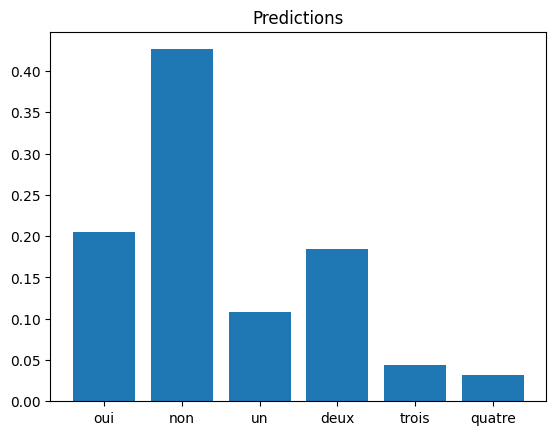

In [18]:
test_file = "output.mp3"
test = pd.DataFrame({'path' : [test_file], 'sentence': ['test']})
print(test)

sample_ds = preprocess_files(test)
for spectrogram, label in sample_ds.batch(1):   
  prediction = model(spectrogram)
  plt.bar(labels, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions')
  print("Predicted :", labels[np.argmax(tf.nn.softmax(prediction[0]))])
  plt.show()

